### Modifying the initial Random Forest 
##### The initial random forest led me to the realization that the sub-category of socks appeared in two  master categories( Apparel & Accessories), possibly affecting model predictions. I kept original results for comparison, but the remaining models will use an updated labels database, in which socks are only in the master category Apparel. 

This notebook can be used in two ways. To minimize cell runtime, the default stage of the notebook will be to import the pickled model that has already been fit. In this state, you can examine the detailed model results using the metrics I've included, or add your own cells. 
If preferred, you can replicate the original process by following instructions in comments. 


In [22]:
#standard imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#random forest imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, multilabel_confusion_matrix

#pickling import
import dill as pickle

#my childhood soccer number
np.random.seed(33)

In [23]:
df_train = pd.read_csv('data/train_labels.csv')
df_test = pd.read_csv('data/test_labels.csv')

In [24]:
df_train.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,57555,Women,Personal Care,Lips,Lipstick,Pink,Spring,2017.0,NaN,Lotus Herbals SPF-10 Tulip Love Lipstick 417
1,43488,Men,Apparel,Topwear,Shirts,Beige,Summer,2012.0,Casual,French Connection Men Beige Shirt
2,12420,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2011.0,Casual,Timberland Men Casual Black Casual Shoes
3,51405,Men,Apparel,Topwear,Shirts,Red,Summer,2012.0,Casual,Myntra Men Red & White Striped Shirt
4,57091,Women,Apparel,Bottomwear,Skirts,Black,Summer,2012.0,Casual,Elle Women Black Skirt


In [25]:
# loaded2 = np.load('data/color_images.npz')
# color_train = loaded2['a']
# color_test = loaded2['b']

loaded2 = np.load('data/bw_images.npz')
X_train = loaded2['a']
X_test = loaded2['b']

In [26]:
#loaded = np.load('data/shuffle_arrays.npz')
#shuffle_train = loaded['a']
#shuffle_test = loaded['b']

### Generate categorical labels for master categories by assigning numbers (0 to 3) to each category, in alphabetical order. 

In [212]:
def pick_ylabels(column):
    y_train = df_train[column].copy().astype('category').cat.codes
    y_test = df_test[column].copy().astype('category').cat.codes
    return (y_train.values, y_test.values)

def category_codes(column):
    _, ytest = pick_ylabels(column)
    cat_codes = {}
    cat_code_list = []
    for i in range(len(df_test[column].value_counts().index)):
        s = df_test[column].value_counts().index[i]
        t = df_test[column].value_counts().index[i]
        cat_codes[s] = t
        cat_code_list.append(s, t)

    for key in sorted(cat_codes):
        print("%s: %s" % (key, cat_codes[key]))
    return cat_code_list

def test_counts_by_cat(column):
    _, ytest = pick_ylabels(column)
    test_counts_dict = {}
    test_counts = []
    for i in range(len(df_test[column].value_counts().index)):
        s = df_test[column].value_counts().values[i]
        t = df_test[column].value_counts().index[i]
        test_counts_dict[t] = s
        test_counts.append([t, s])
#     for i in sorted(test_counts):
#         print("%s: %s" % (test_counts[0], test_counts[1]))
    return test_counts

def class_weights(column):
    test_counts = test_counts_by_cat(column)
    counts_list = []
    ratio_list = []
    ratio_dict = {}
    for x in test_counts:
        counts_list.append(x[1])
    #print(counts_list)
    z = sum(counts_list)
    for x in counts_list:
        if np.round(x/z, 2) ==0:
            ratio_list.append(.005)
        else: 
            ratio_list.append(np.round(x/z, 2))
    for k, v in enumerate(ratio_list):
        ratio_dict[k] = v
    return ratio_dict

In [209]:
pick_ylabels('subCategory')

(array([18, 35, 28, ..., 16, 35, 35], dtype=int8),
 array([34, 27, 34, ...,  2, 34, 34], dtype=int8))

In [195]:
# with open('models_pkl/random_forest.pkl', 'rb') as fit_rf:
#     clf = pickle.load(fit_rf)

In [196]:
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_1),y_train_1)
# class_weights

In [197]:
rfc_master = RandomForestClassifier(n_estimators = 100, random_state=33, class_weight={0:0.2, 1:0.05, 2:0.2, 3:0.1})
rfc_master.fit(X_train, y_train_1)

KeyboardInterrupt: 

In [218]:
def fit_rfc(column):
    weights = class_weights(column)
    y_train, _ = pick_ylabels(column)
    model = RandomForestClassifier(n_estimators = 100, random_state=33, class_weight=weights)
    model.fit(X_train, y_train)
    return model

In [219]:
fit_master = fit_rfc('masterCategory')

In [222]:
fit_master.predict(X_test)

array([1, 2, 1, ..., 0, 1, 1], dtype=int8)

In [221]:
type(fit_master)

sklearn.ensemble.forest.RandomForestClassifier

In [41]:
rfc_master = RandomForestClassifier(n_estimators = 100, random_state=33, class_weight={0:0.2, 1:0.05, 2:0.2, 3:0.1})
rfc_master.fit(X_train, y_train_1)

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.2, 1: 0.05, 2: 0.2, 3: 0.1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=33, verbose=0, warm_start=False)

In [220]:
master_accuracy, master_recall, master_mishaps = model_results(fit_master, 'masterCategory')

AttributeError: 'str' object has no attribute 'predict'

In [42]:
with open('models_pkl/rf_master.pkl', 'wb') as x:
    pickle.dump(rfc_master, x)

In [48]:
def model_results(model, column):
    yhat = model.predict(X_test)
    _ , ytest = pick_ylabels(column)
    accuracy = accuracy_score(ytest, yhat)
    print( 'Accuracy Score: ', accuracy )
    recall = recall_score(ytest, yhat, average='weighted')
    print( 'Recall Score: ', recall)
    y_proba = rfc_master.predict_proba(X_test)
    wrong_id_list = []
    pred_cat_list = []
    real_cat_list = []
    for row_idx in range(len(ytest)):
        if ytest[row_idx]!=yhat[row_idx]:
            wrong_id_list.append(row_idx)
            pred_cat_list.append(yhat[row_idx])
            real_cat_list.append(ytest[row_idx])

    arr = np.array([ real_cat_list, pred_cat_list])
    arr = arr.transpose()
    wrong_df = pd.DataFrame( arr, index= wrong_id_list, columns = ['actual', 'predicted'] )
    return (accuracy, recall, wrong_df)

In [50]:
master_acc, master_recall, master_wrong_df = model_results(y_test_1, rfc_master)

Accuracy Score:  0.9800478850758181
Recall Score:  0.9800478850758181


In [57]:
def false_negatives(column, wrong_df):
    category_list = list(df_test[column].value_counts().index)
    FN_counts_by_cat = {}
    for x in range(len(category_list)):
        FN = wrong_df[wrong_df.actual == x]
        FN_counts_by_cat[category_list[x]] = (len(FN))
    return FN_counts_by_cat
# Have a look at False Negatives
# category_list = ['Accessories', 'Apparel', 'Footwear', 'Personal Care']
# FN_counts_by_cat = {}
# for x in range(len(category_list)):
#     FN = wrong_df[wrong_df.actual == x]
#     FN_counts_by_cat[category_list[x]] = (len(FN))
# print(FN_counts_by_cat)

In [58]:
false_negatives('subCategory', master_wrong_df)

{'Topwear': 74,
 'Shoes': 39,
 'Bags': 18,
 'Bottomwear': 44,
 'Watches': 0,
 'Innerwear': 0,
 'Eyewear': 0,
 'Fragrance': 0,
 'Jewellery': 0,
 'Sandal': 0,
 'Wallets': 0,
 'Flip Flops': 0,
 'Socks': 0,
 'Belts': 0,
 'Loungewear and Nightwear': 0,
 'Saree': 0,
 'Dress': 0,
 'Lips': 0,
 'Nails': 0,
 'Ties': 0,
 'Makeup': 0,
 'Headwear': 0,
 'Scarves': 0,
 'Apparel Set': 0,
 'Cufflinks': 0,
 'Skin': 0,
 'Accessories': 0,
 'Stoles': 0,
 'Skin Care': 0,
 'Eyes': 0,
 'Mufflers': 0,
 'Perfumes': 0,
 'Gloves': 0,
 'Shoe Accessories': 0,
 'Bath and Body': 0,
 'Sports Accessories': 0,
 'Hair': 0}

In [62]:
test_count_by_cat = np.array(list(masterCat_test_counts.values()))
test_FN_by_cat = np.array(list(FN_counts_by_cat.values()))

desperate_arr = [[62, 2189], [32, 4278], [19, 1827], [51, 477]]
false_id_df = pd.DataFrame(desperate_arr, index=category_list, columns=['Number of Incorrect Predictions','Number of Items in Test Data'])
false_id_df['Percent Incorrect'] = round(false_id_df.iloc[:,0]/false_id_df.iloc[:,1],2)
false_id_df

SyntaxError: invalid syntax (<ipython-input-62-6eabfcd3a898>, line 3)

In [41]:
FN_accessories = wrong_df[wrong_df.actual == 0]
FN_acc = FN_accessories.predicted.apply(lambda x: masterCat_codes[x])
FN_acc_idx = list(FN_accessories.index)

FN_apparel = wrong_df[wrong_df.actual == 1]
FN_app = FN_apparel.predicted.apply(lambda x: masterCat_codes[x])
FN_app_idx = list(FN_apparel.index)

FN_footwear = wrong_df[wrong_df.actual == 2]
FN_foot = FN_footwear.predicted.apply(lambda x: masterCat_codes[x])
FN_foot_idx = list(FN_footwear.index)

FN_personal = wrong_df[wrong_df.actual == 3]
FN_pc = FN_personal.predicted.apply(lambda x: masterCat_codes[x])
FN_pc_idx = list(FN_personal.index)

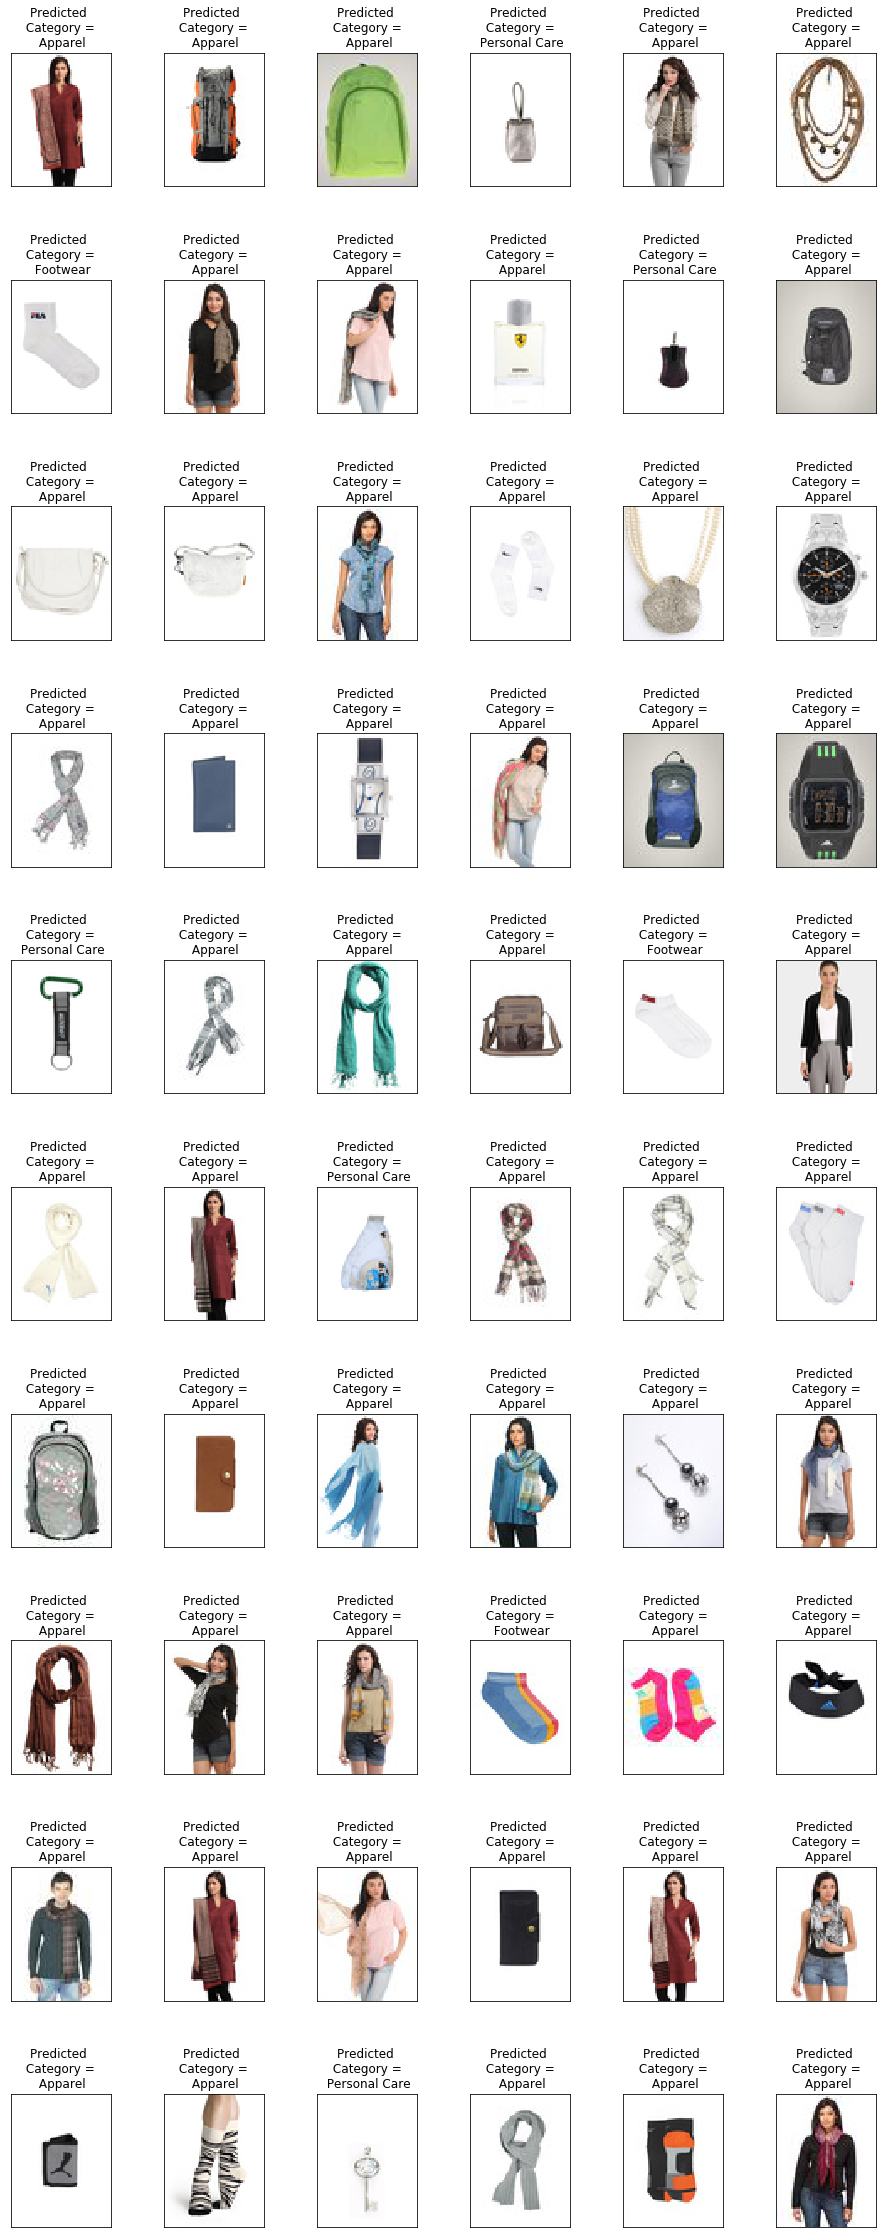

In [61]:
fig, axs = plt.subplots(10, 6, figsize=(16,40))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[FN_acc_idx[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(FN_acc.values[i]))
plt.subplots_adjust(hspace = 0.7)

In [30]:
#orig_index = list(shuffle_test[accessory_false_neg])

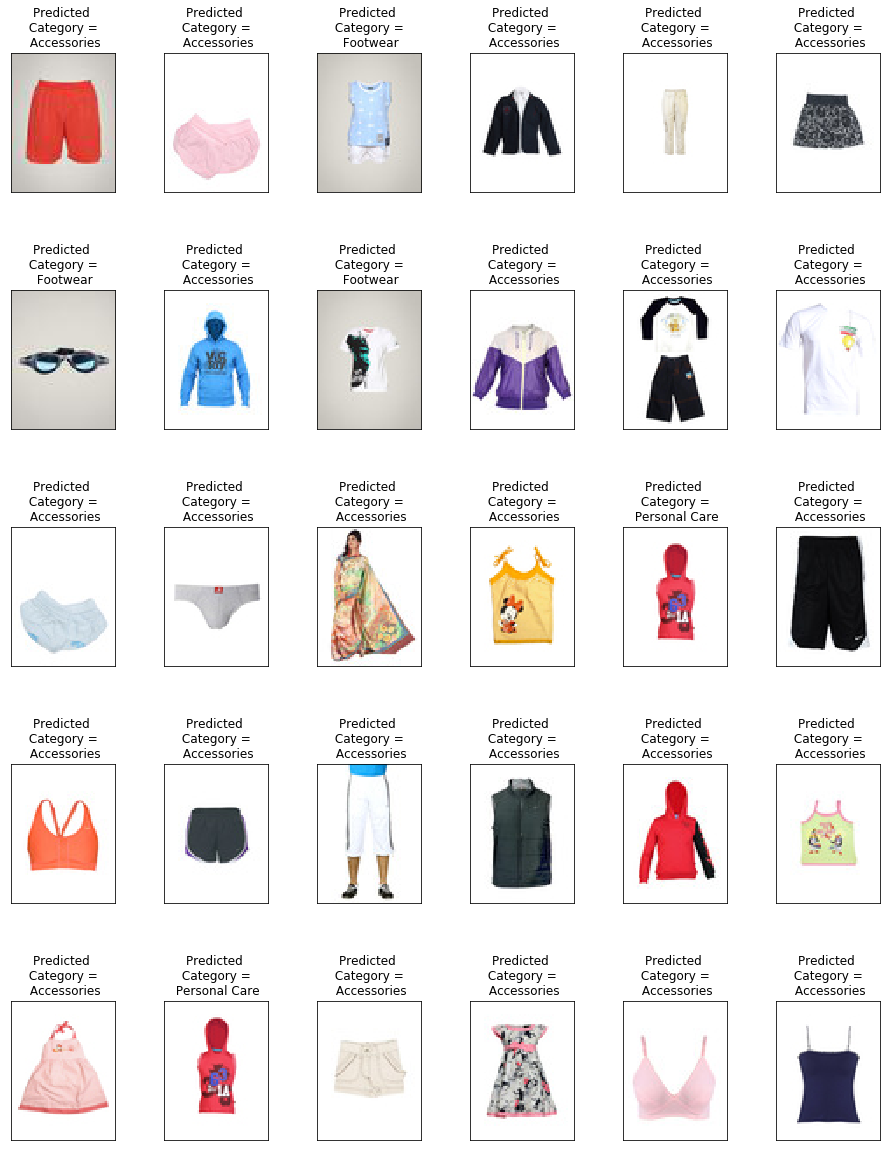

In [59]:
fig, axs = plt.subplots(5, 6, figsize=(16,20))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[FN_app_idx[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(FN_app.values[i]))
plt.subplots_adjust(hspace = 0.7)

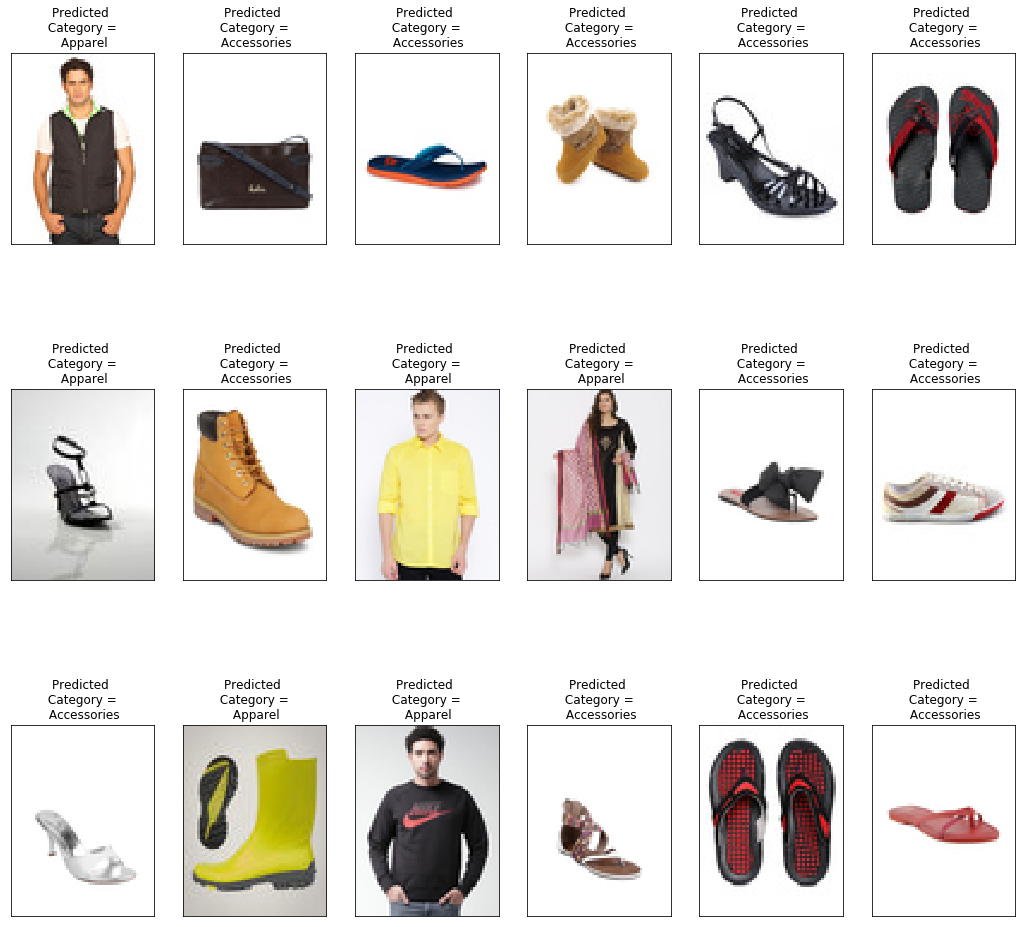

In [51]:
fig, axs = plt.subplots(3, 6, figsize=(18,16))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[FN_foot_idx[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(FN_foot.values[i]))
plt.subplots_adjust(hspace = 0.7)

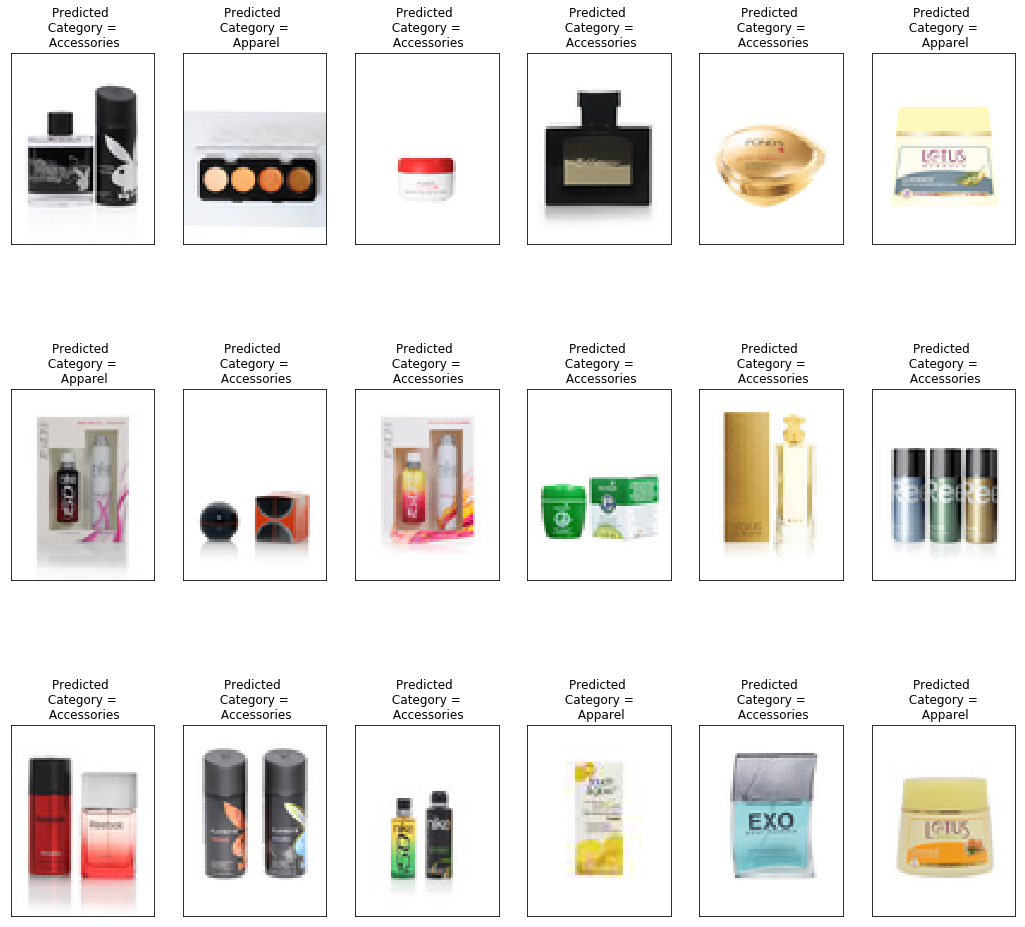

In [60]:
fig, axs = plt.subplots(3, 6, figsize=(18,16))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[FN_pc_idx[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(FN_pc.values[i]))
plt.subplots_adjust(hspace = 0.7)

Double Check that labels and images are correctly aligned after TT Split:

In [ ]:
# load pre-split labels and images
orig_idx_labels = pd.read_csv('data/labels_df.csv')
loaded3 = np.load('data/full_image_arr.npz')
orig_img_array = loaded3['a']
orig_idx = shuffle_test[FN_acc_idx]

NameError: name 'orig_img_array' is not defined

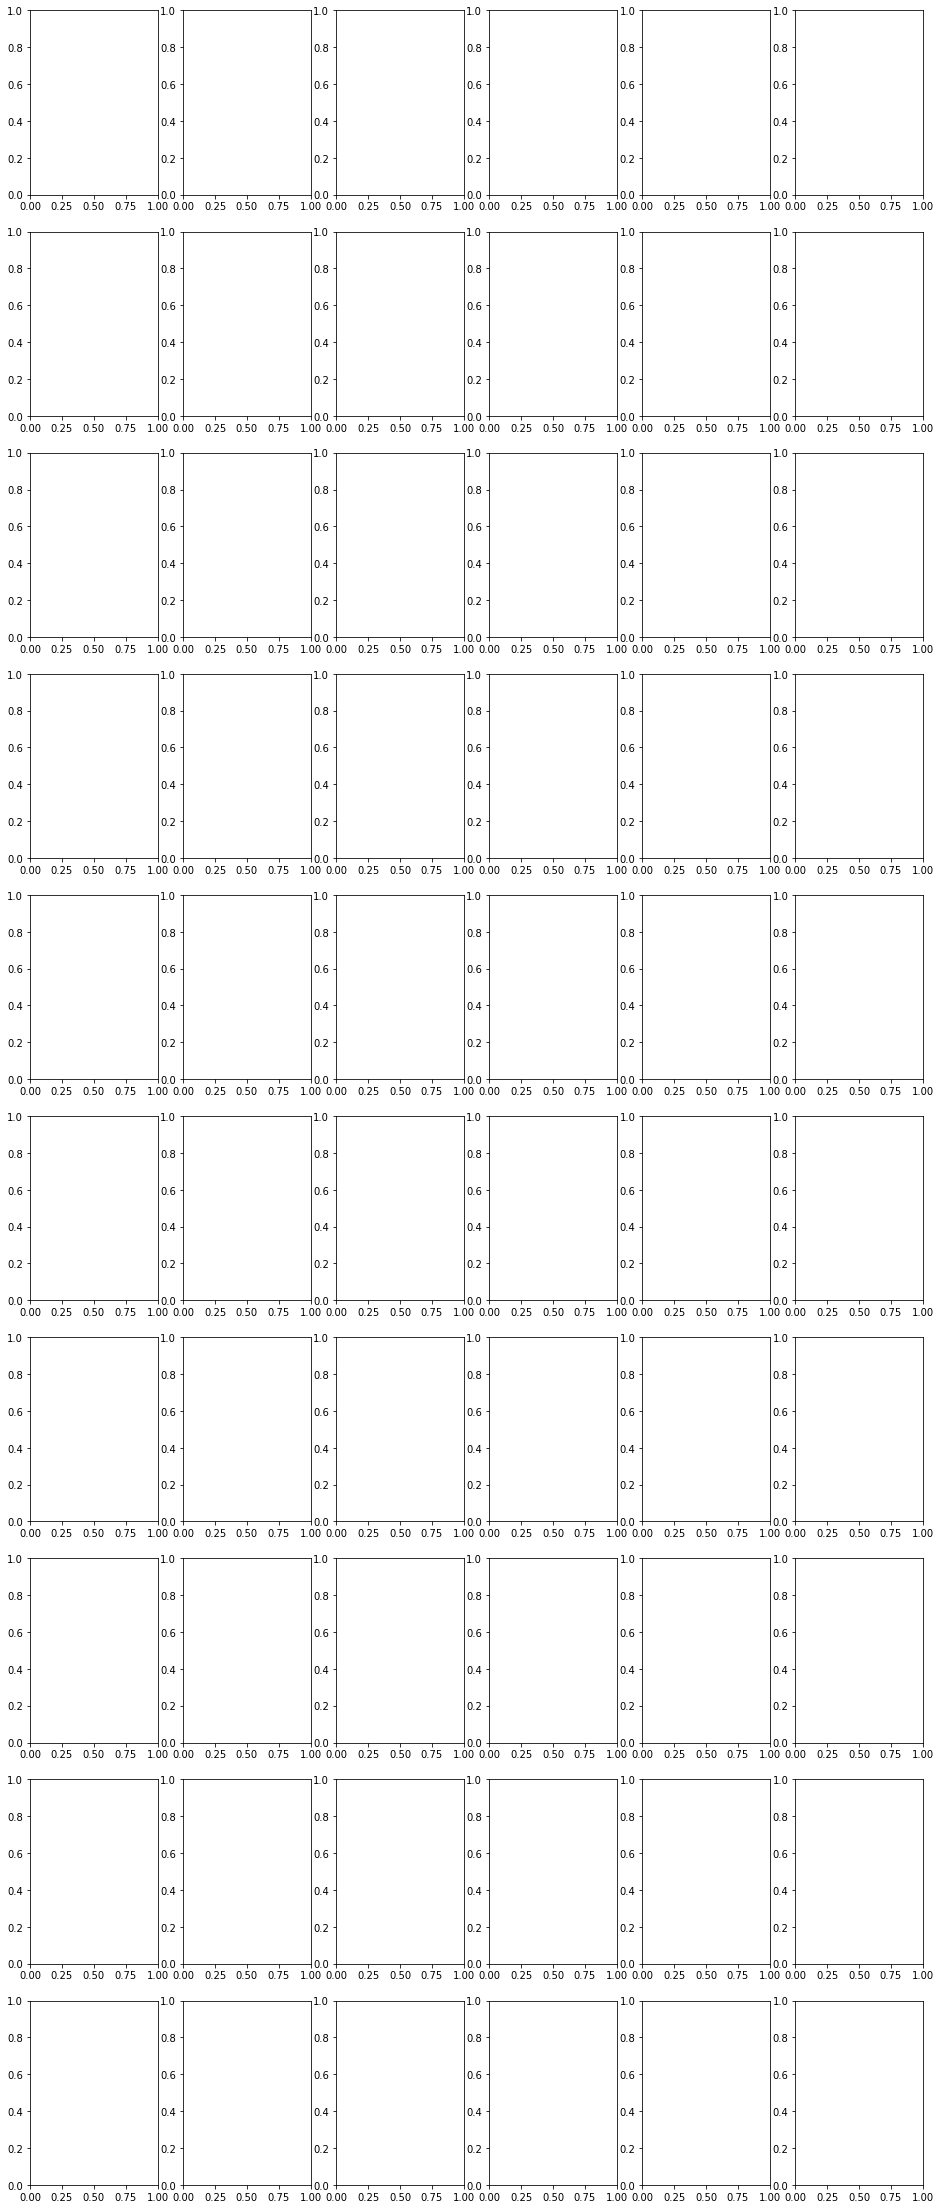

In [85]:
fig, axs = plt.subplots(10, 6, figsize=(16,40))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( orig_img_array[orig_idx[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    ax.set_title('Predicted \n Category = \n {}'.format(FN_acc.values[i]))
plt.subplots_adjust(hspace = 0.7)

In [31]:
mult_conf_mat = multilabel_confusion_matrix(y_test, yhat, labels=[0,1,2,3])

In [34]:
for i in range(4):
    print(f'Confusion Matrix \n for {category_list[i]}:')
    print(mult_conf_mat[i])
    print('\n')

Confusion Matrix 
 for Accessories:
[[6502   80]
 [  62 2127]]


Confusion Matrix 
 for Apparel:
[[4423   70]
 [  32 4246]]


Confusion Matrix 
 for Footwear:
[[6938    6]
 [  19 1808]]


Confusion Matrix 
 for Personal Care:
[[8286    8]
 [  51  426]]




In [76]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1], pos_label=1)

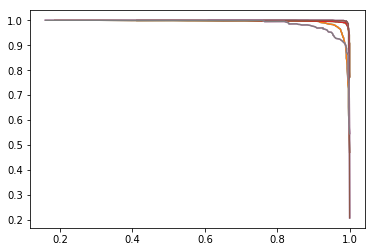

In [25]:
precision_list = []
recall_list = []
thresh_list = []
for i in range(4):
    p, r, t = precision_recall_curve(y_test, y_proba[:,i], pos_label=i)
    precision_list.append(p[:-1])
    recall_list.append(r[:-1])
    thresh_list.append(t)
    #print(p.shape)
    #print(t.shape)
    plt.plot( recall_list[i], precision_list[i])
    plt.plot( recall_list[i], precision_list[i])

In [ ]:
'''%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
carrier_count = cat_df_flights['carrier'].value_counts()
sns.set(style="darkgrid")
sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
plt.title('Frequency Distribution of Carriers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Carrier', fontsize=12)
plt.show()'''